# Постановка задач
существует мировая сеть приемников ГНСС. Данные этой сети можно использовать для исследования влияния движения МКС на атмосферу (ионосферу)

## до начала работы необходимо поставить пакет coordinates (conda install coordinates / pip install coordinates)

In [ ]:
import numpy as np
import pandas as pd              # работа с таблицами
import matplotlib.pyplot as plt  # графики
from geopy import distance
from math import radians, cos, sin, asin, sqrt
from numba import jit, njit

In [2]:
# данные о пролетах МКС за 2014 год:
# file = './iss/ISS_2014.1.h5'
# data = pd.read_hdf(file)    
# data = data[:60*60*24]
# 
# data.to_hdf('one_day_data.h5',key='df', complevel=4)

file = 'one_day_data.h5'
data = pd.read_hdf(file)    

In [3]:
data = pd.read_csv('temp.csv', names='time lat lon alt'.split(),skiprows=1)
lat_rad = []
lon_rad = []
for i in data.index[:]:
    lat_rad.append(np.deg2rad(data.lat[i]))
data.insert(loc=len(data.columns), column='lat_rad', value=lat_rad)

for i in data.index[:]:
    lon_rad.append(np.deg2rad(data.lon[i]))
data.insert(loc=len(data.columns), column='lon_rad', value=lon_rad)

In [4]:
#data.index = data['Unnamed: 0']; del data['Unnamed: 0']
data

,time,lat,lon,alt,lat_rad,lon_rad
0,2014-01-01 00:00:00,-50.333535,-0.742741,433.111337,-0.878486,-0.012963
1,2014-01-01 00:00:01,-50.349450,-0.649372,433.114031,-0.878764,-0.011334
2,2014-01-01 00:00:02,-50.365284,-0.555937,433.116692,-0.879040,-0.009703
3,2014-01-01 00:00:03,-50.381035,-0.462438,433.119321,-0.879315,-0.008071
4,2014-01-01 00:00:04,-50.396704,-0.368874,433.121917,-0.879588,-0.006438
...,...,...,...,...,...,...
86395,2014-01-01 23:59:55,51.121425,179.125495,422.904394,0.892237,3.126330
86396,2014-01-01 23:59:56,51.132453,179.222486,422.910568,0.892430,3.128022
86397,2014-01-01 23:59:57,51.143393,179.319525,422.916721,0.892621,3.129716
86398,2014-01-01 23:59:58,51.154246,179.416612,422.922854,0.892810,3.131411


ValueError: Length mismatch: Expected axis has 6 elements, new values have 3 elements

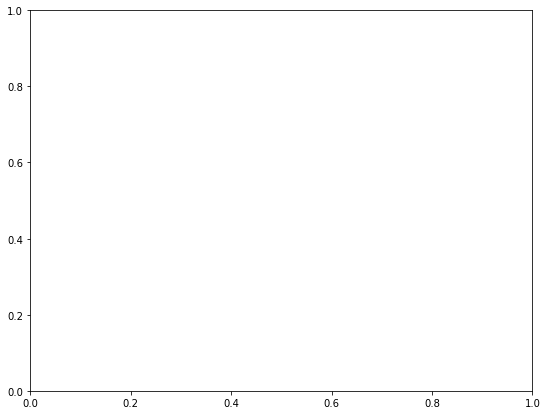

In [5]:
# Подготовим рисунок:
fig, ax = plt.subplots(figsize=(9,7))

data.columns = 'lat', 'lon', 'alt'
minute_resolution = data[::60]
minute_resolution[:120].plot(x='lon', y='lat', ax=ax)

plt.grid(ls=":")
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [6]:
minute_resolution[:120].index

NameError: name 'minute_resolution' is not defined

## задача 1: 
нам нужно определить даты и интервалы времени, когда МКС находилась над областями плотного расположения приемников.
Мы возьмем три региона: Калифорния, Япония и Европа

In [7]:
path = './regions'
stations = []  # список, содержащий таблицы по каждому из трех регионов
for region in 'cal', 'jap', 'eur':
    stations.append(pd.read_csv(f'{path}/{region}.lst', names='site lat lon'.split()))
    

In [8]:
sites = stations[0]# это первые 10 станций в Калифорнии
stations

[      site      lat       lon
 0     7odm  34.1167 -117.0932
 1     acsb  33.2745 -117.4449
 2     agmt  34.5947 -116.4294
 3     alpp  34.8248 -118.6948
 4     alth  36.8899 -120.6698
 ...    ...      ...       ...
 1243  kdcb  36.3835 -119.0906
 1244  plmo  39.4333 -121.6046
 1245  port  36.0413 -119.0169
 1246  sod2  37.1664 -121.9255
 1247  spig  31.0461 -115.4660
 
 [1248 rows x 3 columns],
      site      lat       lon
 0    0194  39.1859  139.5477
 1    019b  39.1859  139.5477
 2    aira  31.8244  130.5996
 3    ccj2  27.0678  142.1950
 4    chan  43.7910  125.4442
 ..    ...      ...       ...
 187  khab  48.4954  135.0499
 188  uskh  47.0350  142.7165
 189  plvs  30.8431  121.5215
 190  prt2  43.1226  133.1261
 191  brgv  42.7711  133.0608
 
 [192 rows x 3 columns],
      site      lat      lon
 0    acor  43.3647  -8.3989
 1    ajac  41.9278   8.7626
 2    alac  38.3392  -0.4812
 3    alme  36.8528  -2.4594
 4    ambl  49.8597   0.9943
 ..    ...      ...      ...
 942  rets

In [9]:
site = sites.iloc[12]

Написать функцию: для заданной станции она возвращает моменты времени, когда МКС проходила над станцией (или в заданном радиусе от нее)

In [16]:
s_lat = site.lat
s_lon = site.lon
data2 = data[['lat','lon']].copy()
data2.insert(loc=len(data2.columns), column='dlat', value=data2.lat-s_lat)
data2.insert(loc=len(data2.columns), column='dlon', value=data2.lon-s_lon)
def my_filter(col):
    return col['dlon'] < 5
t = data2[data2.apply(my_filter, axis='columns')]
t

def Haversine(lat1, lon1, lat2, lon2, radius=0):
    # print([type(i) for i in (lat1, lat2, lon1, lon2)])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * 6371 * asin(sqrt(a))  
    if (c < radius):
        d = True
    else:
        d = False
    return d

def when_iss_passed(station, iss_track, radius=0):
    lat1 = station.lat
    lon1 = station.lon
    ind = []
    for i in iss_track.index[:]:
        item = iss_track.loc[i]
        lat2 = item.lat
        lon2 = item.lon
        h = Haversine(lat1, lon1, lat2, lon2, radius)
        if (h == True): ind.append(i)
    return ind
when_iss_passed(site, data2, 200)

[10996,
 25576,
 28222,
 29608,
 31497,
 42481,
 47858,
 49987,
 50504,
 51460,
 59268,
 63415,
 68476,
 82526,
 84170]

In [48]:
def Haversine(lat1, lon1, lat2, lon2, radius=0):
    # print([type(i) for i in (lat1, lat2, lon1, lon2)])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * 6371 * asin(sqrt(a))  
    if (c < radius):
        d = True
    else:
        d = False
    return d

def when_iss_passed(station, iss_track, radius=0):
    lat1 = np.deg2rad(station.lat)
    lon1 = np.deg2rad(station.lon)
    ind = []
    for i in iss_track.index[:]:
        item = iss_track.loc[i]
        lat2 = item.lat_rad
        lon2 = item.lon_rad
        h = Haversine(lat1, lon1, lat2, lon2, radius)
        if (h == True): ind.append(i)
    return ind

time       2014-01-01 00:00:01
lat                   -50.3494
lon                  -0.649372
alt                    433.114
lat_rad              -0.878764
lon_rad             -0.0113337
Name: 1, dtype: object

0.6015905585529175


-2.044723031881437


In [51]:
when_iss_passed(site, data, 200)

[]

In [15]:
result = []
for i in sites.index[:3]:
    site = sites.iloc[i]
    result.append(when_iss_passed(site, data, 200))
    print(result[-1])

KeyboardInterrupt: 

In [16]:
data.head()

,time,lat,lon,alt
0,2014-01-01 00:00:00,-50.333535,-0.742741,433.111337
1,2014-01-01 00:00:01,-50.349450,-0.649372,433.114031
2,2014-01-01 00:00:02,-50.365284,-0.555937,433.116692
3,2014-01-01 00:00:03,-50.381035,-0.462438,433.119321
4,2014-01-01 00:00:04,-50.396704,-0.368874,433.121917


In [20]:
sites.iloc[2]

site       agmt
lat     34.5947
lon    -116.429
Name: 2, dtype: object

In [21]:
data.iloc[result[-1]]

,time,lat,lon,alt
18724,2014-01-01 05:12:04,22.049399,46.943455,414.878467
26575,2014-01-01 07:22:55,3.177983,172.604693,419.967619
27428,2014-01-01 07:37:08,-37.732317,-151.000568,429.549254
31635,2014-01-01 08:47:15,28.300656,128.611427,420.906516
31704,2014-01-01 08:48:24,25.078076,131.780574,420.533138
35782,2014-01-01 09:56:22,37.666410,-6.487659,418.301728
59747,2014-01-01 16:35:47,15.743538,21.796122,419.872785
62275,2014-01-01 17:17:55,-28.256391,178.887758,421.578160
63802,2014-01-01 17:43:22,43.921439,-113.300314,420.135865
65442,2014-01-01 18:10:42,9.486814,2.935261,419.808596


## задача 2: 
Для заданного момента времени определить положение спутников GPS, GLONASS, таких, что лучи от них до заданной станции траекторию МКС

In [44]:
import gnss_tec
import datetime as dt
from coordinates import satellite_xyz
from sat_geometry_lite import xyz_to_el_az, sub_ionospheric

In [41]:
import json
# Читаем список станций
with open('base.json','rb') as file:
    sites = json.load(file)

In [42]:
sat_num = 1
nav_file = '/home/ilya/Data/Rinex/nav/tmp/brdc2560.14n'
gnss_type = 'G'

In [45]:
timestamp = dt.datetime(2014, 9, 13, 14)

site = sites[0]
#site_xyz = [-4073662.27, 4712064.75, -1367874.49 ]
site_xyz = site['xyz']
sat_xyz = satellite_xyz(nav_file, gnss_type, sat_num, timestamp)

In [46]:
# углы положения спутника на небе восхождение (elevation) и азимут (azimuth)
el, az = xyz_to_el_az(site_xyz, sat_xyz)

In [47]:
# определение координат точки пересечения луча со слоем на высоте h
h = 455
sub_ionospheric(-12.4667792, 130.8439872, h, az, el)    

(-0.6479963234863083, 124.38363008210126)

In [49]:
# функция возвращает нам моменты, когда лучи от станции до спутников ГНСС пересекали траекторию МКС
# опция radius дает допустимое расхождение между положением станции и ионосферной точкой (точкой пересечения) луча
def get_crossections(day, site, radius=0):
    pass